In [230]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle


from sklearn.decomposition import PCA

from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


import random
import tensorflow as tf

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [231]:
def get_initial_11(team):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'][:11].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

## Top 15
Nos sirve para tener mas jugadores para entrenar, no nos interesan todos porque hay algunos que juegan muy poco y pueden cambiar mucho los resultados pero el top 15 suele ser el que mas participa

In [232]:
def get_frequent_players(team, min_minutes=1400):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        
        df_filtered = df[df['MinutesPlayed'] > min_minutes]
        
        df_filtered = df_filtered.sort_values(by='MinutesPlayed', ascending=False)
        
        return df_filtered['PlayerName'].tolist()
    
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [233]:
def get_team_players(team):
    base_path = '//Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    team_data_path = os.path.join(base_path, team, f'{team}_summary.csv')
    try:
        df = pd.read_csv(team_data_path)
        df = df.drop_duplicates()
        df = df.sort_values(by='MinutesPlayed', ascending=False)
        return df['PlayerName'].tolist()
    except FileNotFoundError:
        print(f'Error: El archivo {team}_summary.csv no se encontró en la carpeta de {team}.')
        return None
    except Exception as e:
        print(f'Error al cargar el archivo para {team}: {str(e)}')
        return None

In [234]:
def load_player_matrix(team_name, player_name, matrix_name):
    base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'
    if matrix_name != 'pass_transition_matrix':
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.csv')
        matrix = np.loadtxt(matrix_path, delimiter=',')
    else:
        matrix_path = os.path.join(base_path, team_name, player_name, f'{matrix_name}.npy')
        matrix = np.load(matrix_path)
    return matrix

In [235]:
def aggregate_team_matrices(team, players):
    team_matrixes = {
        'pass_matrix':  np.zeros((10, 10)),
        'shot_matrix': np.zeros((10, 10)),
        'defense_matrix': np.zeros((10, 10)),
        'goal_matrix': np.zeros((10, 10)),
        'errors_matrix': np.zeros((10, 10)),
        'out_matrix': np.zeros((10, 10))
    }

    for player in players:
        team_matrixes['pass_matrix'] += load_player_matrix(team, player, 'pass_matrix')
        team_matrixes['shot_matrix'] += load_player_matrix(team, player, 'shot_matrix')
        team_matrixes['defense_matrix'] += load_player_matrix(team, player, 'defense_matrix')
        team_matrixes['goal_matrix'] += load_player_matrix(team, player, 'goal_matrix')
        team_matrixes['errors_matrix'] += load_player_matrix(team, player, 'errors_matrix')
        team_matrixes['out_matrix'] += load_player_matrix(team, player, 'out_matrix') 
    
    return team_matrixes

In [236]:
teams_list = ['Arsenal', 'Everton', 'Fulham', 'Manchester City',
       'Newcastle United', 'Queens Park Rangers', 'Reading',
       'West Bromwich Albion', 'West Ham United', 'Wigan Athletic',
       'Aston Villa', 'Chelsea', 'Liverpool', 'Manchester United',
       'Norwich City', 'Southampton', 'Stoke City', 'Sunderland',
       'Swansea City', 'Tottenham Hotspur', 'Vancouver Whitecaps', 'Philadelphia Union', 'Chivas USA',
       'FC Dallas', 'Seattle Sounders FC', 'Houston Dynamo',
       'Portland Timbers', 'LA Galaxy', 'San Jose Earthquakes',
       'Colorado Rapids', 'Chicago Fire', 'D.C. United', 'Toronto FC',
       'New York Red Bulls', 'Sporting Kansas City', 'Montreal Impact',
       'Real Salt Lake', 'Columbus Crew', 'New England Revolution']

## Construccion del dataframe con informacion de jugadores

In [237]:
base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'

team_matrixes = {}
player_matrixes = {}
all_players = []

for team in teams_list:
    team_csv_path = os.path.join(base_path, f"{team}/{team}_summary.csv")
    team_data = pd.read_csv(team_csv_path)
    
    players = get_frequent_players(team) 
    for player in players:
        if player not in player_matrixes:
            player_matrixes[player] = {}
        
        types = {
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'errors_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))
        }
        
        all_players.append(player)
        
        for type_name in types:
            
            player_matrixes[player][type_name] = load_player_matrix(team, player, type_name)
        
        player_info = team_data[team_data['PlayerName'] == player]
        if not player_info.empty:
            position = player_info['Position'].values[0]
            cards = player_info['Cards'].values[0]
            time_played = player_info['MinutesPlayed'].values[0]
            player_matrixes[player]['team'] = team
            player_matrixes[player]['position'] = position
            player_matrixes[player]['cards'] = cards
            player_matrixes[player]['time'] = time_played

    team_matrixes[team] = aggregate_team_matrices(team, players)

In [238]:
for team in teams_list:
    for matrix in team_matrixes[f'{team}']:
        team_matrixes[f'{team}'][matrix] = np.sum(team_matrixes[f'{team}'][matrix] * 90)

In [239]:
for player in all_players:
    for matrix_name, matrix_value in player_matrixes[f'{player}'].items():
        if matrix_name == 'cards':
            player_matrixes[f'{player}'][matrix_name] = matrix_value
        elif matrix_name == 'time':
            player_matrixes[f'{player}'][matrix_name] = matrix_value / 90
        elif matrix_name == 'position' or matrix_name == 'team':
            pass
        else:
            player_matrixes[f'{player}'][matrix_name] = matrix_value

In [240]:
player_dataframe = pd.DataFrame(player_matrixes).T

In [241]:
player_dataframe['position'] = player_dataframe['position'].replace('Forward', 'Striker')

In [242]:
regions = [
    (slice(0, 5), slice(0, 10)),  
    (slice(5, 10), slice(0, 10)),  
    (slice(2, 8), slice(3, 7)),   
    (slice(0, 2), slice(0, 10)),  
    (slice(8, 10), slice(0, 10)), 
]

def matrix_to_vector(matrix):
    return np.array([np.sum(matrix[region]) for region in regions])

In [243]:
matrix_columns = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for column in matrix_columns:
    player_dataframe[column] = player_dataframe[column].apply(matrix_to_vector)

## Agregado de metricas de participación

In [244]:
# for team in teams_list:
#     team_stats = team_matrixes[team]
#     for player in get_frequent_players(team):
#         if player in player_dataframe.index:
#             for stat_name, stat_value in team_stats.items():
#                 player_dataframe.loc[player, f'{stat_name}_team'] = stat_value

In [245]:
# metrics = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

# for metric in metrics:
#     player_dataframe[f'{metric}_contribution'] = player_dataframe[metric] / player_dataframe[f'{metric}_team']

In [246]:
player_dataframe = player_dataframe.round(2)

In [247]:
player_dataframe = player_dataframe.reset_index().rename(columns={'index': 'player'})

In [248]:
player_dataframe

,player,pass_matrix,shot_matrix,defense_matrix,goal_matrix,errors_matrix,out_matrix,team,position,cards,time
0,"Cazorla, Santiago","[0.14219, 0.48671899999999996, 0.230948, 0.004...","[0.0, 0.033579, 0.012846999999999999, 0.0, 0.0...","[0.06949599999999999, 0.043216000000000004, 0....","[0.0, 0.003504, 0.000292, 0.0, 0.0032120000000...","[0.018688, 0.023068, 0.011387999999999999, 0.0...","[0.017228, 0.014015999999999999, 0.008176, 0.0...",Arsenal,Midfielder,0.000292,38.055556
1,"Mertesacker, Per","[0.448762, 0.039487, 0.21529399999999999, 0.02...","[0.0, 0.005327999999999999, 0.0, 0.0, 0.005328]","[0.10749199999999999, 0.009399999999999999, 0....","[0.0, 0.0009390000000000001, 0.0, 0.0, 0.00093...","[0.041994000000000004, 0.005952, 0.01378999999...","[0.008456000000000002, 0.0065769999999999995, ...",Arsenal,Defender,0.001254,35.455556
2,"Arteta, Mikel","[0.388082, 0.42544, 0.4467, 0.010304, 0.008693...","[0.0, 0.006118, 0.002254, 0.0, 0.0038640000000...","[0.110461, 0.039287, 0.059574999999999996, 0.0...","[0.0, 0.0019320000000000001, 0.0, 0.0, 0.00193...","[0.034777, 0.012236, 0.018677, 0.010304, 0.000...","[0.009982, 0.0077280000000000005, 0.00322, 0.0...",Arsenal,Midfielder,0.001932,34.5
3,"Giroud, Olivier","[0.031348999999999995, 0.15146199999999999, 0....","[0.0, 0.043565, 0.005293000000000001, 0.0, 0.0...","[0.025237, 0.06066400000000001, 0.031756, 0.00...","[0.0, 0.004478, 0.0, 0.0, 0.004478]","[0.017505, 0.0684, 0.032573, 0.011807, 0.017912]","[0.017908000000000004, 0.016687, 0.009768, 0.0...",Arsenal,Striker,0.001629,27.288889
4,"Walcott, Theo","[0.027253, 0.162267, 0.026415, 0.001677, 0.041...","[0.0, 0.036477, 0.005031000000000001, 0.0, 0.0...","[0.026414, 0.024737000000000002, 0.009641, 0.0...","[0.0, 0.00587, 0.0, 0.0, 0.005870000000000001]","[0.005449, 0.020124, 0.0071270000000000005, 0....","[0.013415, 0.010476, 0.007124999999999999, 0.0...",Arsenal,Striker,0.001258,26.5
...,...,...,...,...,...,...,...,...,...,...,...
480,Chris Tierney,"[0.13098600000000002, 0.170322, 0.025145999999...","[0.0, 0.007709, 0.0032449999999999996, 0.0, 0....","[0.08678699999999999, 0.018657999999999998, 0....","[0.0, 0.000406, 0.0, 0.0, 0.000406]","[0.040556999999999996, 0.010548, 0.00405799999...","[0.027177, 0.018257999999999996, 0.012575, 0.0...",New England Revolution,Defender,0.000811,27.4
481,Scott Caldwell,"[0.18284999999999998, 0.176121, 0.243377, 0.00...","[0.00042, 0.002521, 0.002101, 0.00042, 0.00042]","[0.096675, 0.027322, 0.056324, 0.026901, 0.0]","[0.00042, 0.0, 0.0, 0.00042, 0.0]","[0.034045, 0.009665, 0.017233, 0.010929, 0.00042]","[0.009663000000000001, 0.008404, 0.00420000000...",New England Revolution,Midfielder,0.001261,26.433333
482,Bobby Shuttleworth,"[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]",New England Revolution,Goalkeeper,0.0,23.988889
483,A.J. Soares,"[0.22468500000000002, 0.021618, 0.117177, 0.01...","[0.0, 0.0028449999999999994, 0.000569, 0.0, 0....","[0.160409, 0.010240999999999998, 0.04778100000...","[0.0, 0.000569, 0.0, 0.0, 0.000569]","[0.064279, 0.002276, 0.018772000000000004, 0.0...","[0.028447, 0.016499999999999997, 0.01194899999...",New England Revolution,Defender,0.002275,19.533333


In [249]:
def split_matrix_column(df, column_name):
    zones_df = pd.DataFrame((df[column_name] * 90).tolist(), 
                            columns=[f"{column_name}_zone_{i+1}" for i in range(5)])
    return zones_df

matrix_columns = ['pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 'errors_matrix', 'out_matrix']

for column in matrix_columns:
    zones_df = split_matrix_column(player_dataframe, column)
    player_dataframe = pd.concat([player_dataframe, zones_df], axis=1)
    player_dataframe.drop(columns=[column], inplace=True)

In [250]:
player_dataframe

,player,team,position,cards,time,pass_matrix_zone_1,pass_matrix_zone_2,pass_matrix_zone_3,pass_matrix_zone_4,pass_matrix_zone_5,...,errors_matrix_zone_1,errors_matrix_zone_2,errors_matrix_zone_3,errors_matrix_zone_4,errors_matrix_zone_5,out_matrix_zone_1,out_matrix_zone_2,out_matrix_zone_3,out_matrix_zone_4,out_matrix_zone_5
0,"Cazorla, Santiago",Arsenal,Midfielder,0.000292,38.055556,12.79710,43.80471,20.78532,0.44676,3.75786,...,1.68192,2.07612,1.02492,0.44676,0.23652,1.55052,1.26144,0.73584,0.70956,0.31536
1,"Mertesacker, Per",Arsenal,Defender,0.001254,35.455556,40.38858,3.55383,19.37646,2.51010,0.19746,...,3.77946,0.53568,1.24110,2.42559,0.22563,0.76104,0.59193,0.36648,0.19728,0.16902
2,"Arteta, Mikel",Arsenal,Midfielder,0.001932,34.5,34.92738,38.28960,40.20300,0.92736,0.78246,...,3.12993,1.10124,1.68093,0.92736,0.08694,0.89838,0.69552,0.28980,0.28980,0.14490
3,"Giroud, Olivier",Arsenal,Striker,0.001629,27.288889,2.82141,13.63158,6.88905,0.07326,2.52846,...,1.57545,6.15600,2.93157,1.06263,1.61208,1.61172,1.50183,0.87912,0.47619,0.58608
4,"Walcott, Theo",Arsenal,Striker,0.001258,26.5,2.45277,14.60403,2.37735,0.15093,3.73599,...,0.49041,1.81116,0.64143,0.15084,0.64152,1.20735,0.94284,0.64125,0.37728,0.30177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Chris Tierney,New England Revolution,Defender,0.000811,27.4,11.78874,15.32898,2.26314,1.05858,2.51847,...,3.65013,0.94932,0.36522,1.60605,0.25569,2.44593,1.64322,1.13175,0.87615,0.32868
481,Scott Caldwell,New England Revolution,Midfielder,0.001261,26.433333,16.45650,15.85089,21.90393,0.49185,0.11340,...,3.06405,0.86985,1.55097,0.98361,0.03780,0.86967,0.75636,0.37800,0.26478,0.07560
482,Bobby Shuttleworth,New England Revolution,Goalkeeper,0.0,23.988889,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
483,A.J. Soares,New England Revolution,Defender,0.002275,19.533333,20.22165,1.94562,10.54593,1.02393,0.05121,...,5.78511,0.20484,1.68948,2.76444,0.15363,2.56023,1.48500,1.07541,0.81927,0.30726


## Agregamos la variable a predecir: el ranking

In [251]:
ranking_PL = pd.read_excel('/Users/luisalawson/Desktop/Ranking.xlsx')
ranking_MLS = pd.read_excel('/Users/luisalawson/Desktop/RankingMLS.xlsx')

In [252]:
ranking_PL['League'] = 'PL'
ranking_MLS['League'] = 'MLS'

ranking = pd.concat([ranking_PL, ranking_MLS], ignore_index=True)

In [253]:
ranking.reset_index(drop=True, inplace=True)

In [254]:
player_dataframe = player_dataframe.merge(ranking[['Equipo', 'Posicion', 'League']], left_on='team', right_on='Equipo', how='left')
player_dataframe = player_dataframe.drop(columns=['Equipo'])
player_dataframe = player_dataframe.rename(columns={'Posicion': 'TeamRanking'})

## Modelo clasificador

In [255]:
# player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))

In [256]:
player_dataframe = player_dataframe[player_dataframe['position'] != 'Goalkeeper']
# player_dataframe = player_dataframe[player_dataframe['position'] != 'Striker']

In [257]:
player_dataframe['position'].value_counts()

position
Midfielder    173
Defender      171
Striker       103
Name: count, dtype: int64

In [258]:
# Si queremos que sean 3 clases (probar mas adelante, ya probe y no dio tanta diferencia, mejor 5)
player_dataframe['TeamRanking'] = player_dataframe['TeamRanking'].apply(
    lambda x: 0 if x <= 9 else 1 
)

In [259]:
columns_to_round = player_dataframe.select_dtypes(include=['float64', 'int64']).columns
player_dataframe[columns_to_round] = np.ceil(player_dataframe[columns_to_round])

## Clusters

In [260]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

In [261]:
player_dataframe['cards'] = pd.to_numeric(player_dataframe['cards'], errors='coerce')
player_dataframe['time'] = pd.to_numeric(player_dataframe['time'], errors='coerce')

In [262]:
numeric_features = [
    'pass_matrix_zone_1', 'pass_matrix_zone_2', 
    'pass_matrix_zone_3', 'pass_matrix_zone_4', 'pass_matrix_zone_5', 
    'shot_matrix_zone_1', 'shot_matrix_zone_2', 'shot_matrix_zone_3', 
    'shot_matrix_zone_4', 'shot_matrix_zone_5', 'defense_matrix_zone_1', 
    'defense_matrix_zone_2', 'defense_matrix_zone_3', 'defense_matrix_zone_4', 
    'defense_matrix_zone_5', 'goal_matrix_zone_1', 'goal_matrix_zone_2', 
    'goal_matrix_zone_3', 'goal_matrix_zone_4', 'goal_matrix_zone_5', 
    'errors_matrix_zone_1', 'errors_matrix_zone_2', 'errors_matrix_zone_3', 
    'errors_matrix_zone_4', 'errors_matrix_zone_5', 'out_matrix_zone_1', 
    'out_matrix_zone_2', 'out_matrix_zone_3', 'out_matrix_zone_4', 
    'out_matrix_zone_5', 'TeamRanking', 'cards', 'time'
]

categorical_features = [ 'position', 'League']

In [263]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified in the transformers
)


In [264]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [265]:
X_clusters = pipeline.fit_transform(player_dataframe)

In [266]:
inertia = []
silhouette_scores = []

In [267]:
range_n_clusters = range(2, 11)  # Testing from 2 to 10 clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_clusters)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clusters, kmeans.labels_))

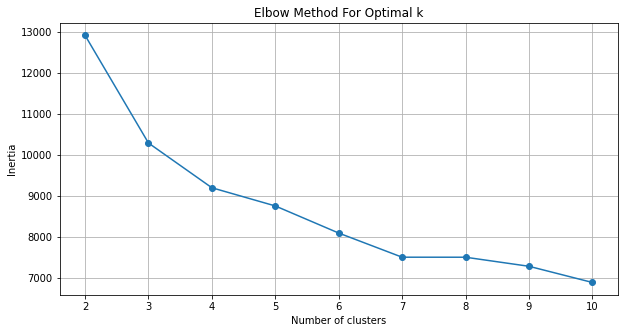

In [268]:
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

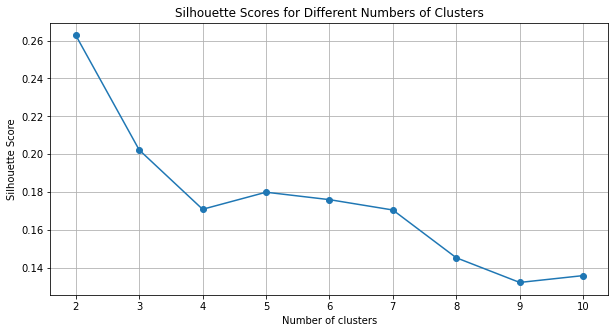

In [269]:
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [270]:
optimal_clusters = 4

In [271]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
player_dataframe['Cluster'] = kmeans.fit_predict(X_clusters)

In [272]:
player_dataframe

,player,team,position,cards,time,pass_matrix_zone_1,pass_matrix_zone_2,pass_matrix_zone_3,pass_matrix_zone_4,pass_matrix_zone_5,...,errors_matrix_zone_4,errors_matrix_zone_5,out_matrix_zone_1,out_matrix_zone_2,out_matrix_zone_3,out_matrix_zone_4,out_matrix_zone_5,TeamRanking,League,Cluster
0,"Cazorla, Santiago",Arsenal,Midfielder,0.000292,38.055556,13.0,44.0,21.0,1.0,4.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,PL,2
1,"Mertesacker, Per",Arsenal,Defender,0.001254,35.455556,41.0,4.0,20.0,3.0,1.0,...,3.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,PL,1
2,"Arteta, Mikel",Arsenal,Midfielder,0.001932,34.500000,35.0,39.0,41.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,PL,3
3,"Giroud, Olivier",Arsenal,Striker,0.001629,27.288889,3.0,14.0,7.0,1.0,3.0,...,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,PL,2
4,"Walcott, Theo",Arsenal,Striker,0.001258,26.500000,3.0,15.0,3.0,1.0,4.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,PL,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,Diego Fagundez,New England Revolution,Midfielder,0.001104,30.188889,4.0,14.0,4.0,1.0,3.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,MLS,2
480,Chris Tierney,New England Revolution,Defender,0.000811,27.400000,12.0,16.0,3.0,2.0,3.0,...,2.0,1.0,3.0,2.0,2.0,1.0,1.0,0.0,MLS,1
481,Scott Caldwell,New England Revolution,Midfielder,0.001261,26.433333,17.0,16.0,22.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,MLS,0
483,A.J. Soares,New England Revolution,Defender,0.002275,19.533333,21.0,2.0,11.0,2.0,1.0,...,3.0,1.0,3.0,2.0,2.0,1.0,1.0,0.0,MLS,1


In [273]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Supongamos que ya tienes tu DataFrame con clusters asignados
# player_dataframe['Cluster'] = kmeans.fit_predict(X_clusters)

# Asegúrate de que solo estés utilizando columnas numéricas
numeric_columns = player_dataframe.select_dtypes(include=[np.number]).columns.tolist()

# Función para generar nuevos puntos de datos a partir de un cluster
def generate_new_samples(cluster_data, n_samples=30):
    new_samples = []
    for _ in range(n_samples):
        # Elegir dos índices aleatorios de puntos en el cluster
        idx1, idx2 = np.random.choice(cluster_data.index, size=2, replace=False)
        # Obtener los puntos correspondientes (solo las columnas numéricas)
        point1 = cluster_data.loc[idx1, numeric_columns]
        point2 = cluster_data.loc[idx2, numeric_columns]
        # Interpolar entre los dos puntos
        new_sample_ = (point1 + point2) / 2 # Promedio
        new_sample = new_sample_.apply(lambda x: np.random.choice([0, 1]) if x == 0.5 else round(x))
        new_samples.append(new_sample)
    
    return pd.DataFrame(new_samples)

# Crear un DataFrame vacío para almacenar los nuevos datos
new_data = pd.DataFrame()

# Iterar sobre cada cluster y generar nuevos datos
for cluster in player_dataframe['Cluster'].unique():
    cluster_data = player_dataframe[player_dataframe['Cluster'] == cluster]
    new_samples = generate_new_samples(cluster_data, n_samples=5)  # Ajusta n_samples según tus necesidades
    new_samples['Cluster'] = cluster  # Asigna el mismo cluster a los nuevos datos
    new_data = pd.concat([new_data, new_samples], ignore_index=True)

# Combinar los nuevos datos con el DataFrame original (solo columnas numéricas)
augmented_dataframe = pd.concat([player_dataframe, new_data], ignore_index=True)


/var/folders/3t/sdkd8jss1x3b8wld4zwvm2kh0000gn/T/ipykernel_6639/1909440834.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  augmented_dataframe['position'].fillna(player_dataframe['Common_Position'], inplace=True)


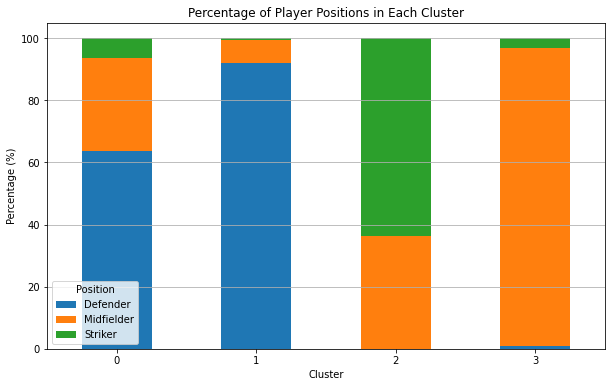

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que 'player_dataframe' ya tiene la columna 'Cluster' asignada
# Calcular la posición más común para cada cluster
most_common_position = player_dataframe.groupby('Cluster')['position'].agg(lambda x: x.mode()[0]).reset_index()
most_common_position.columns = ['Cluster', 'Common_Position']

# Combinar el DataFrame original con el DataFrame de posiciones comunes
player_dataframe = player_dataframe.merge(most_common_position, on='Cluster', how='left')

# Rellenar la columna 'position' con la posición común del cluster
augmented_dataframe['position'].fillna(player_dataframe['Common_Position'], inplace=True)

# Opcionalmente, puedes eliminar la columna 'Common_Position' si no la necesitas
player_dataframe.drop(columns=['Common_Position'], inplace=True)

# Visualizar el porcentaje de posiciones en cada cluster
position_counts = augmented_dataframe.groupby(['Cluster', 'position']).size().unstack(fill_value=0)
position_percentage = position_counts.div(position_counts.sum(axis=1), axis=0) * 100
position_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Percentage of Player Positions in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage (%)')
plt.legend(title='Position')
plt.xticks(rotation=0)  
plt.grid(axis='y')

plt.show()


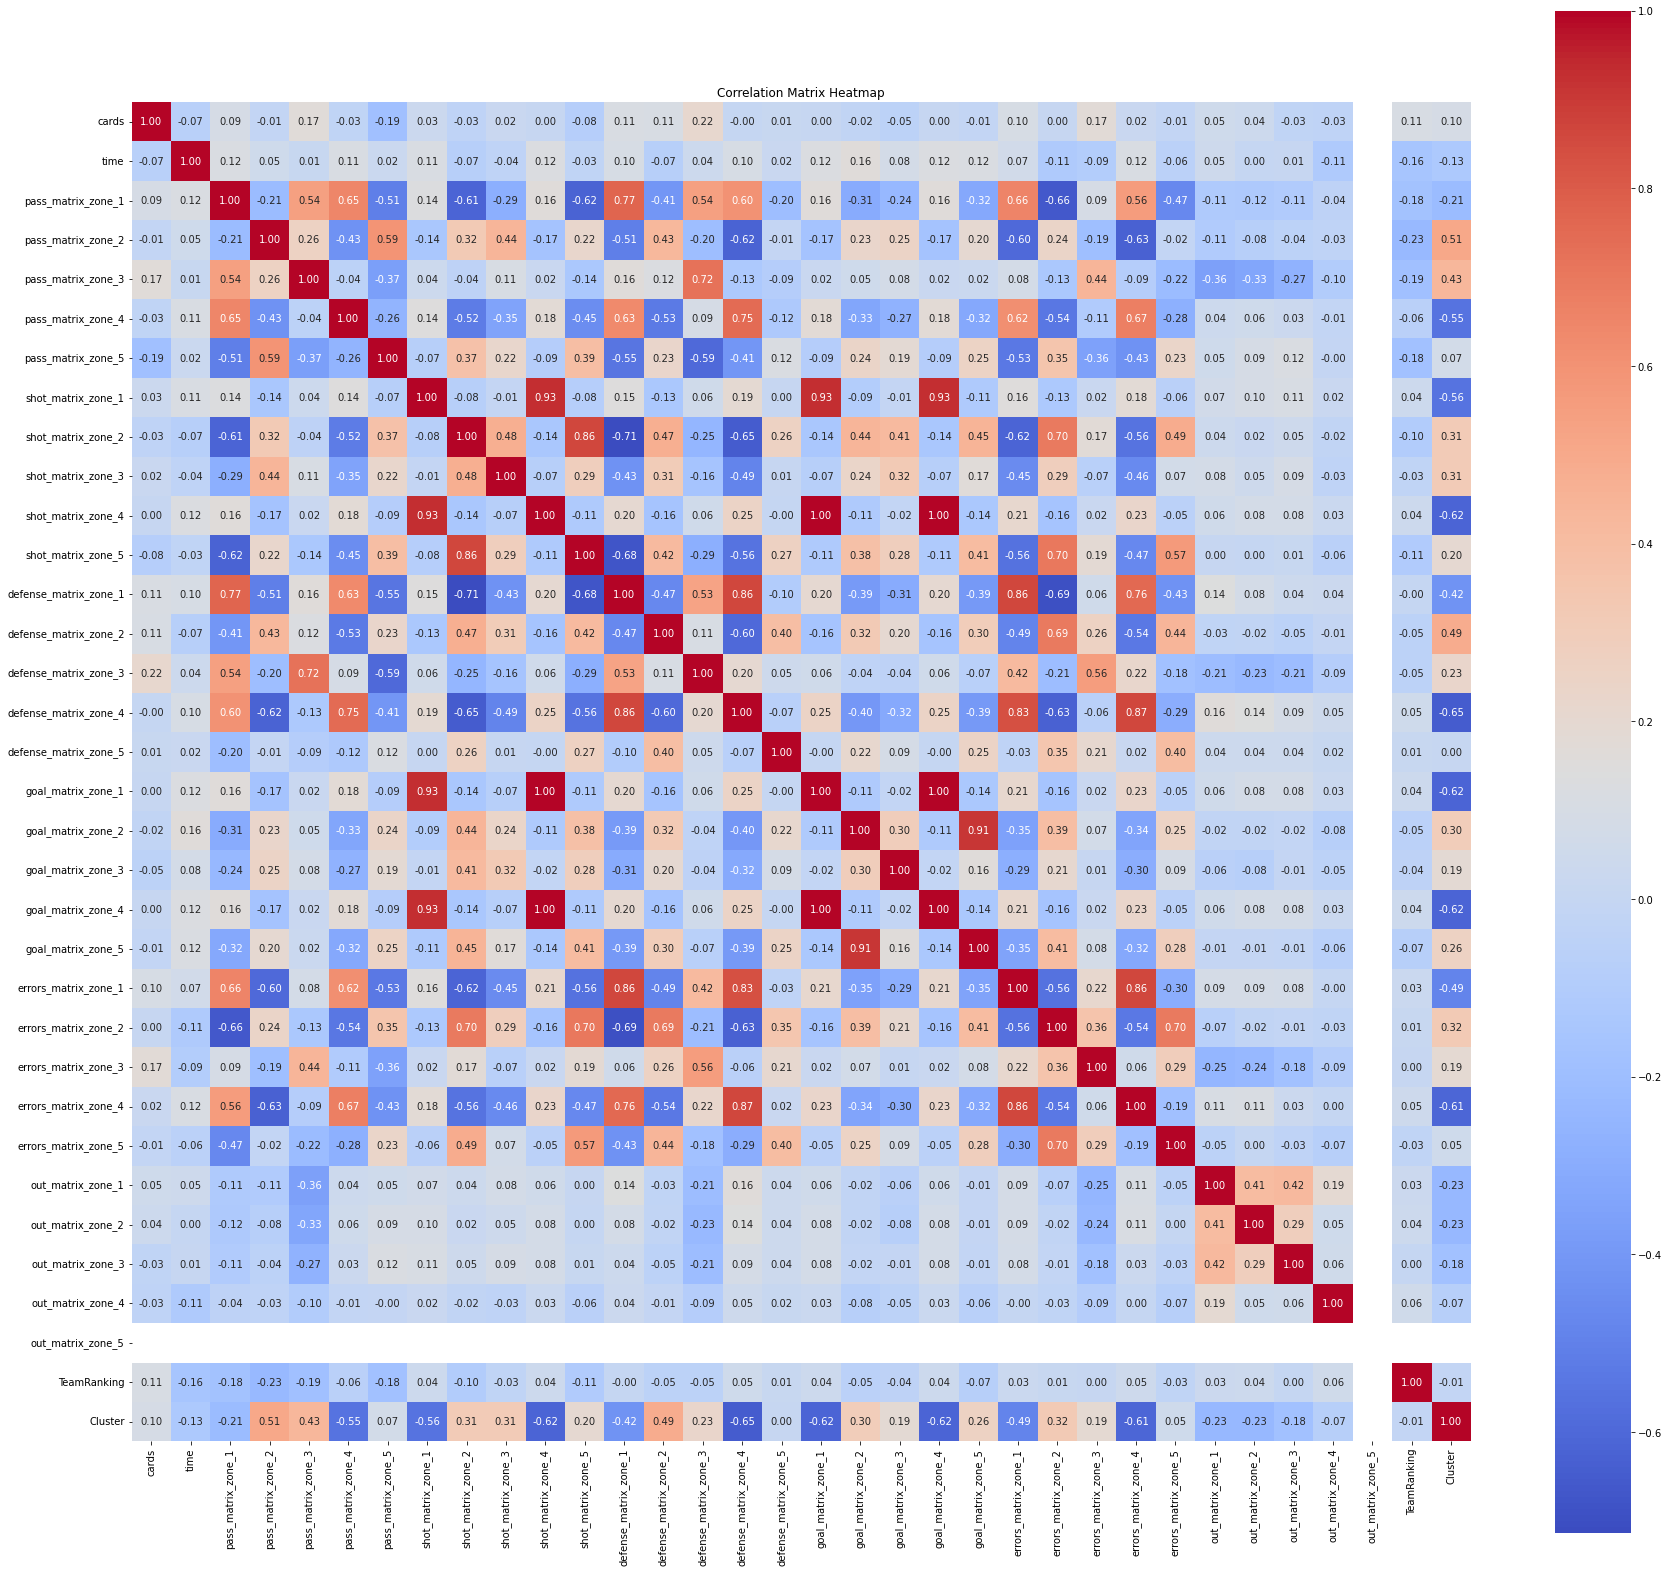

In [275]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming player_dataframe is already defined and contains your data
# player_dataframe = pd.read_csv('your_file.csv')  # Load your data here

# Select only the numeric columns
numeric_df = augmented_dataframe.select_dtypes(include=['float64', 'int64','int32'])

# Optionally drop rows with any NaN values (if necessary)
numeric_df = numeric_df.dropna()

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(30,28))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Set titles and labels
plt.title('Correlation Matrix Heatmap')
plt.show()


## Training - clusters 0 and 1

In [276]:
# eliminamos el nombre (no me aporta en nada), el equipo (porque se correlaciona con el ranking y seria data leak) 
# y el team Ranking porque es lo que queremos predecir
filtered_dataframe = augmented_dataframe[~augmented_dataframe['Cluster'].isin([2, 3])]
X = filtered_dataframe.drop(columns=['player', 'team', 'TeamRanking', 'time', 'cards'])
# nos quedamos con la variable a predecir
y = filtered_dataframe['TeamRanking']
X, y = shuffle(X, y, random_state=42)
X = pd.get_dummies(X, columns=['position', 'League'], drop_first=False)

In [277]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [278]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = keras.Sequential([
    layers.Dense(32, activation='linear', kernel_regularizer=regularizers.l2(0.1), input_shape=(X_train.shape[1],)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.4),  # Increased dropout
    layers.Dense(16, activation='linear'),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2, activation='softmax')  # Output layer for binary classification
])

model.compile(optimizer=Adam(learning_rate=0.005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.4810 - loss: 3.9078 - val_accuracy: 0.5000 - val_loss: 3.3090
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6335 - loss: 3.0864 - val_accuracy: 0.3824 - val_loss: 2.7422
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6112 - loss: 2.5788 - val_accuracy: 0.4118 - val_loss: 2.2653
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5558 - loss: 2.1314 - val_accuracy: 0.4412 - val_loss: 1.8698
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6751 - loss: 1.7211 - val_accuracy: 0.5000 - val_loss: 1.5580
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6540 - loss: 1.4451 - val_accuracy: 0.5000 - val_loss: 1.3268
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7152 - loss: 1.2014 - val_accuracy: 0.5000 - val_loss: 1.1524
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6734 - loss: 1.0421 - val_accuracy: 0.4706 - val_loss: 1.0244
Epoc

In [453]:
## MODELOS QUE YA PROBAMOS

# accuracy: 0.9124 - val_accuracy: 0.4792 - test_accuracy: 0.4799
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     #si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#     layers.Dense(5, activation='softmax')
# ])

# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.BatchNormalization(),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')
# ])


# val_acc -> 0.27 | acc -> 0.6
# model = models.Sequential([
#     layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.4),
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
#     layers.Dropout(0.3),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

# val_acc -> 0.22 | acc -> 0.4

# model = models.Sequential([
#     layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)),
#     layers.Dropout(0.3),
#     layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#si cambiamos la agrupacion del ranking cambiar en el out de esta
#     layers.Dense(5, activation='softmax')  
# ])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6265 - loss: 0.6761
Test Accuracy: 0.64


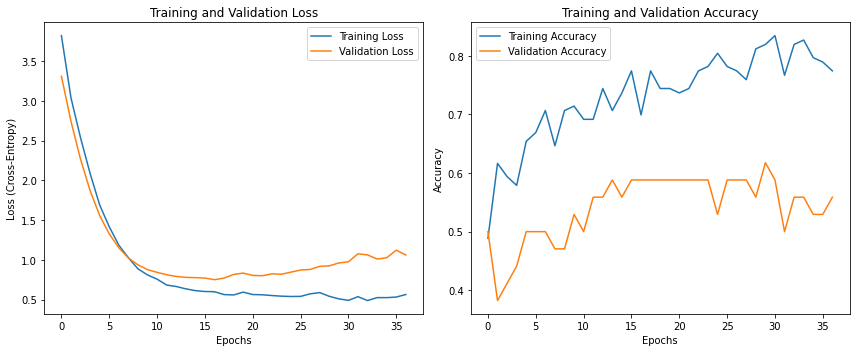

In [279]:
# Vemos como da en test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

# graficos de accuracy y de loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [280]:
y_pred_proba = model.predict(X_test)
y_pred_proba_positive = y_pred_proba[:, 1] 

nn_fpr, nn_tpr, _ = roc_curve(y_test, y_pred_proba_positive)
nn_auc = roc_auc_score(y_test, y_pred_proba_positive)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


In [281]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test MAE: {test_loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6265 - loss: 0.6761  
Test MAE: 0.659453809261322


## ROC-AUC comparacion de otros modelos

In [282]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [283]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

rf_y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)
rf_auc = auc(rf_fpr, rf_tpr)

In [284]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=7, min_samples_leaf=4, random_state=42)
gb_model.fit(X_train, y_train)

gb_y_pred_proba = gb_model.predict_proba(X_test)[:, 1]
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_y_pred_proba)
gb_auc = auc(gb_fpr, gb_tpr)

In [285]:
# XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_proba)
xgb_auc = auc(xgb_fpr, xgb_tpr)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:28:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [286]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

gnb_model = GaussianNB()
gnb_model.fit(X_train, y_train)

gnb_y_pred_proba = gnb_model.predict_proba(X_test)[:, 1]  
gnb_y_pred = gnb_model.predict(X_test)

gnb_auc = roc_auc_score(y_test, gnb_y_pred_proba)
gnb_fpr, gnb_tpr, _ = roc_curve(y_test, gnb_y_pred_proba)

print(f"Naive Bayes Accuracy: {accuracy_score(y_test, gnb_y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, gnb_y_pred))


Naive Bayes Accuracy: 0.5714
Classification Report:
               precision    recall  f1-score   support

         0.0       0.43      0.18      0.25        17
         1.0       0.60      0.84      0.70        25

    accuracy                           0.57        42
   macro avg       0.51      0.51      0.47        42
weighted avg       0.53      0.57      0.52        42



In [287]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

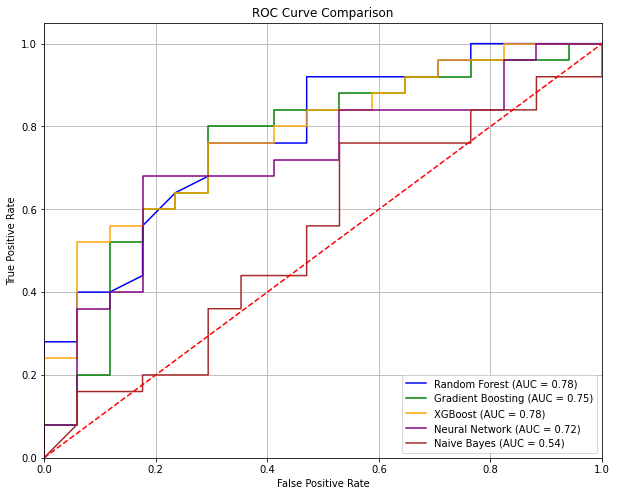

In [288]:
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, color='blue', label='Random Forest (AUC = {:.2f})'.format(rf_auc))
plt.plot(gb_fpr, gb_tpr, color='green', label='Gradient Boosting (AUC = {:.2f})'.format(gb_auc))
plt.plot(xgb_fpr, xgb_tpr, color='orange', label='XGBoost (AUC = {:.2f})'.format(xgb_auc))
plt.plot(nn_fpr, nn_tpr, color='purple', label='Neural Network (AUC = {:.2f})'.format(nn_auc))
plt.plot(gnb_fpr, gnb_tpr, color='brown', label='Naive Bayes (AUC = {:.2f})'.format(gnb_auc))  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Probando el ranking en base al modelo

In [500]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            
            # Check if player_row is empty
            if player_row.empty:
                print(f"Player {player} not found in player_dataframe.")
                continue  # Skip to the next player

            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Midfielder', 
                'position_Striker'
            ]
            league_columns = [
                'League_MLS', 'League_PL'
            ]

            player_position = player_row['position'].values[0]
            player_league = player_row['League'].values[0]

            if player_position == 'Goalkeeper':
                continue 

            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0
            
            for league_col in league_columns:
                player_row.loc[:, league_col] = 1 if player_league in pos_col else 0

            player_row = player_row[required_columns + position_columns + league_columns]

            if player_row.empty:
                print(f"No valid data for player {player} after processing.")
                continue

            player_features = pd.DataFrame(player_row[required_columns + position_columns + league_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    # Average predictions
    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Player Szczesny, Wojciech not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Player Howard, Tim not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Player Schwarzer, Mark not found in player_dataframe.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/

In [501]:
team_rankings_pred_df = pd.DataFrame(team_rankings_pred.items(), columns=['Team', 'PredictedRanking'])

In [502]:
team_rankings_pred_df.sort_values(by='PredictedRanking', ascending=True)
team_rankings_pred_df = team_rankings_pred_df.merge(ranking[['Equipo', 'Posicion']], left_on='Team', right_on='Equipo', how='left')
team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(lambda x: 0 if x <= 4 else (1 if x <= 8 else (2 if x <= 12 else (3 if x <= 16 else 4))))
# si hacemos con 3 descomentar la de abajo y comentar la de arriba
# team_rankings_pred_df['Real'] = team_rankings_pred_df['Posicion'].apply(
#     lambda x: 0 if x <= 6 else (1 if x <= 13 else 2)
# )

team_rankings_pred_df = team_rankings_pred_df.rename(columns={'PredictedRanking': 'Predicted'})


team_rankings_pred_df['diff'] = team_rankings_pred_df['Real'] - team_rankings_pred_df['Predicted']
team_rankings_pred_df = team_rankings_pred_df[['Team', 'Predicted', 'Real', 'diff']]

In [503]:
teams_PL = ranking_PL['Equipo'].unique()
teams_MLS = ranking_MLS['Equipo'].unique()

In [504]:
team_rankings_pred_df = team_rankings_pred_df.sort_values(by='Predicted', ascending=True)
ranking_PL_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_PL)]
ranking_MLS_pred = team_rankings_pred_df[team_rankings_pred_df['Team'].isin(teams_MLS)]

In [505]:
ranking_PL_pred

,Team,Predicted,Real,diff
0,Arsenal,0.000000,0,0.000000
3,Manchester City,0.000000,0,0.000000
13,Manchester United,0.000000,0,0.000000
11,Chelsea,0.000000,0,0.000000
18,Swansea City,0.000000,2,2.000000
12,Liverpool,0.200000,1,0.800000
15,Southampton,0.363636,3,2.636364
19,Tottenham Hotspur,0.400000,1,0.600000
1,Everton,0.800000,1,0.200000
2,Fulham,0.900000,2,1.100000


In [506]:
ranking_MLS_pred

,Team,Predicted,Real,diff
26,Portland Timbers,0.900000,0,-0.900000
25,Houston Dynamo,1.000000,2,1.000000
36,Real Salt Lake,1.000000,1,0.000000
34,Sporting Kansas City,1.400000,0,-1.400000
33,New York Red Bulls,1.600000,0,-1.600000
35,Montreal Impact,2.000000,2,0.000000
27,LA Galaxy,2.000000,1,-1.000000
20,Vancouver Whitecaps,2.454545,3,0.545455
24,Seattle Sounders FC,2.600000,1,-1.600000
23,FC Dallas,2.900000,3,0.100000


## Player swap
#### van Persie, Robin -> Mackie, Jamie

In [32]:
team_rankings_pred = {}

for team in teams_list:
    players = get_initial_11(team)
    if team == 'Manchester United' and 'van Persie, Robin' in players:
        players = [player if player != 'van Persie, Robin' else 'Mackie, Jamie' for player in players]
    
    if team == 'Queens Park Rangers' and 'Mackie, Jamie' in players:
        players = [player if player != 'Mackie, Jamie' else 'van Persie, Robin' for player in players]
        
    player_predictions = []

    for player in players:
        if player in player_matrixes:
            player_row = player_dataframe[player_dataframe['player'] == player].copy()
            required_columns = [
                'pass_matrix', 'shot_matrix', 'defense_matrix', 'goal_matrix', 
                'errors_matrix', 'out_matrix', 'cards', 'time',
                'pass_matrix_contribution', 'shot_matrix_contribution', 
                'defense_matrix_contribution', 'goal_matrix_contribution', 
                'errors_matrix_contribution', 'out_matrix_contribution'
            ]
            position_columns = [
                'position_Defender', 'position_Goalkeeper', 'position_Midfielder', 
                'position_Striker'
            ]

            player_position = player_row['position'].values[0]
            for pos_col in position_columns:
                player_row.loc[:, pos_col] = 1 if player_position in pos_col else 0

            player_row = player_row[required_columns + position_columns]

            player_features = pd.DataFrame(player_row[required_columns + position_columns])
            player_features = scaler.transform(player_features)

            player_prediction = model.predict(player_features)
            predicted_class = np.argmax(player_prediction[0])

            player_predictions.append(predicted_class)
        else:
            print(f"Player {player} not found in player_matrixes")

    if player_predictions:
        team_rankings_pred[team] = np.mean(player_predictions)
    else:
        print(f"No predictions for team {team}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

## Podemos ver de entrenar modelos por posicion

In [40]:
# hay muy pocos datos x ahora especialmente gk
player_dataframe['position'].value_counts()

position
Midfielder    201
Defender      182
Striker       113
Name: count, dtype: int64

## MLS data interpretation

esto ignorarlo es para preparar datos para tener mas para entrenar

In [37]:
MLS_df = pd.read_excel('/Users/luisalawson/Downloads/MLS-Opta.xlsx')

In [38]:
PL_df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter = ';')

In [39]:
MLS_df.drop(labels=['competition_name', 'competition_id'], axis=1, inplace=True)

In [40]:
MLS_df.rename(columns={'id': 'match_id', 'id.1': 'id'}, inplace=True)

In [47]:
PL_df

,season_id,match_id,home_team_id,home_team_name,away_team_id,away_team_name,id,event_id,date,time,...,sec,team_id,player_id,playerName,playerPosition,x,y,type,description,outcome
0,2012,441999,3,Arsenal,56,Sunderland,688830980,1,18Aug2012,2:31:54 PM,...,0,3,NaN,NaN,NaN,0,0,34,Team set up,1
1,2012,441999,3,Arsenal,56,Sunderland,1399442519,1,18Aug2012,2:33:35 PM,...,0,56,NaN,NaN,NaN,0,0,34,Team set up,1
2,2012,441999,3,Arsenal,56,Sunderland,1641098842,2,18Aug2012,3:01:59 PM,...,0,3,NaN,NaN,NaN,0,0,32,Start,1
3,2012,441999,3,Arsenal,56,Sunderland,1755825990,2,18Aug2012,3:01:59 PM,...,0,56,NaN,NaN,NaN,0,0,32,Start,1
4,2012,441999,3,Arsenal,56,Sunderland,164697335,3,18Aug2012,3:02:00 PM,...,1,3,17733.0,"Podolski, Lukas",Striker,50,50,1,Pass,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
648878,2012,442378,111,Wigan Athletic,7,Aston Villa,428661649,905,19May2013,5:51:58 PM,...,35,111,NaN,NaN,NaN,0,0,30,End,1
648879,2012,442378,111,Wigan Athletic,7,Aston Villa,1411196656,907,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,30,End,1
648880,2012,442378,111,Wigan Athletic,7,Aston Villa,948803408,908,19May2013,6:00:29 PM,...,0,111,NaN,NaN,NaN,0,0,37,Collection End,1
648881,2012,442378,111,Wigan Athletic,7,Aston Villa,803034702,810,19May2013,6:00:30 PM,...,0,7,NaN,NaN,NaN,0,0,30,End,1


In [42]:
MLS_df.loc[MLS_df['playerName'] == 'NotSpecified', ['playerName', 'playerPosition']] = ''

In [44]:
MLS_df.loc[MLS_df['playerName'].isin(['NotSpecified', 'NotFound']), ['playerName', 'playerPosition']] = ''

In [49]:
MLS_df['time'] = pd.to_datetime(MLS_df['time'], format='%H:%M:%S').dt.strftime('%I:%M:%S %p')
MLS_df['date'] = pd.to_datetime(MLS_df['date'], format='%Y-%m-%d').dt.strftime('%-d%b%Y')

In [51]:
MLS_df.to_csv('/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data/MLS_df.csv', index=False)